In [2]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import scipy

import warnings
warnings.filterwarnings("ignore")

c:\Users\Joe\OneDrive\Documents\GitHub\synthetic_dimensions\synth_dim_model.py:405: SyntaxWarning: invalid escape sequence '\e'
  ax.set_ylabel("Scaled Energy [$E/N|V| = \epsilon/|V|$]")
c:\Users\Joe\OneDrive\Documents\GitHub\synthetic_dimensions\synth_dim_model.py:422: SyntaxWarning: invalid escape sequence '\R'
  ax1.set_ylabel("$\Re$ Component")
c:\Users\Joe\OneDrive\Documents\GitHub\synthetic_dimensions\synth_dim_model.py:423: SyntaxWarning: invalid escape sequence '\I'
  ax2.set_ylabel("$\Im$ Component")
c:\Users\Joe\OneDrive\Documents\GitHub\synthetic_dimensions\synth_dim_model.py:440: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title(f"Time Evolved $\sigma$: $N={N}$, $M={M}$, $V<0$, $(J/|V|)_f = {J_V_ratio_routine[-1]}$")
c:\Users\Joe\OneDrive\Documents\GitHub\synthetic_dimensions\synth_dim_model.py:441: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel("$\sigma^{01}/M$")


In [3]:
def sigma_ij_operator(i, j, states, N, M):
    """
    Constructs the operator Σ_ij as a matrix that computes the difference in synthetic dimension space
    between sites i and j.

    Parameters:
    i (int): Index of the first site.
    j (int): Index of the second site.
    states (list of lists): List of all states, where each state is represented as a list of occupation numbers.
    N (int): Number of sites.
    M (int): Number of synthetic levels (states per site).

    Returns:
    np.ndarray: The Σ_ij operator as a matrix of shape (dim, dim).
    """
    dim = M**N 
    Sigma_ij = np.zeros((dim, dim))

    for k in range(dim):
        for m in range(M):
            for n in range(M):
                if states[k][i] == m and states[k][j] == n:
                    Sigma_ij[k, k] += abs(m - n)  

    return Sigma_ij

def sigma_ij_from_operator(i, j, wavefunction, states, N, M):
    """
    Computes σ_ij using the operator Σ_ij.

    Parameters:
    i (int): Index of the first site.
    j (int): Index of the second site.
    wavefunction (np.ndarray): State vector of the system.
    states (list of lists): List of all states, where each state is represented as a list of occupation numbers.
    N (int): Number of sites.
    M (int): Number of synthetic levels (states per site).

    Returns:
    float: The sigma value computed as the expectation value of Σ_ij.
    """
    Sigma_ij = sigma_ij_operator(i, j, states, N, M)  # Construct the operator
    expectation_value = np.vdot(wavefunction, Sigma_ij @ wavefunction)  # Compute ⟨ψ|Σ_ij|ψ⟩
    return expectation_value


In [4]:
# checking that the two approaches give the same value of sigma

N = 2
M = 5

states, _ = enumerate_states(N,M)

i = 0
j = 1

J_V_ratios = np.linspace(-2, 2, 10)
for J_V_ratio in J_V_ratios:
    hamiltonian = construct_rescaled_hamiltonian(N,M,V=1,mu_V_ratio=0,J_V_ratio=J_V_ratio)
    eigenvalues, eigenvectors = exact_diagonalize(hamiltonian)
    ground_state = eigenvectors[0]

    val1 = sigma_ij_from_operator(i,j,ground_state,states,N,M)
    val2 = sigma_ij(i,j,ground_state,states,N,M)
    
    print(np.real(val1-val2))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
4.440892098500626e-16
0.0
0.0


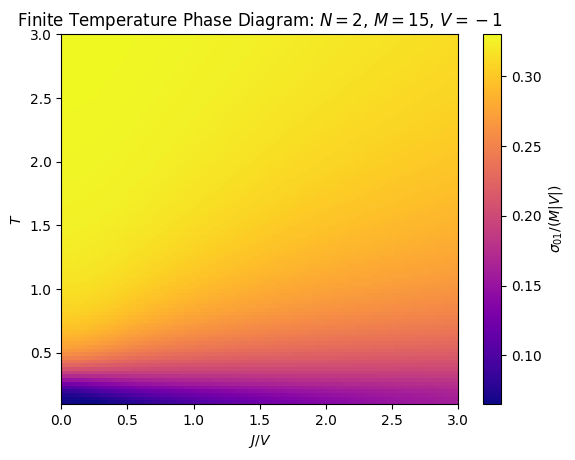

In [17]:
N = 2
M = 15

states, _ = enumerate_states(N,M)

i = 0
j = 1
sigma_op = sigma_ij_operator(i,j,states,N,M)
normalized_sigma_op = sigma_op/M

V = -1
mu_V_ratio = 0

J_V_ratios = np.linspace(0,3,100)
Ts = np.linspace(0.1,3,100)


normalized_sigma_array = np.zeros((len(Ts), len(J_V_ratios)))
for idx1, J_V_ratio in enumerate(J_V_ratios):
    for idx2, T in enumerate(Ts):
        hamiltonian = construct_rescaled_hamiltonian(N, M, V, mu_V_ratio = mu_V_ratio, J_V_ratio = J_V_ratio)
        beta = 1/T
        Z = np.trace(scipy.linalg.expm(-beta * hamiltonian)) 
        density_matrix = scipy.linalg.expm(-beta * hamiltonian) / Z
        normalized_sigma = np.trace(density_matrix @ normalized_sigma_op)
        normalized_sigma_array[idx2,idx1] = normalized_sigma
        
plt.imshow(
    normalized_sigma_array,
    aspect='auto',
    origin='lower',
    cmap='plasma',
    extent=[J_V_ratios[0], J_V_ratios[-1], Ts[0], Ts[-1]],
)
plt.colorbar(label="$\sigma_{01}/(M|V|)$")
plt.xlabel("$J/V$")
plt.ylabel("$T$")
plt.title(f"Finite Temperature Phase Diagram: $N = {N}$, $M = {M}$, $V = {V}$")
plt.show()